In [1]:
from datetime import date as Date, timedelta
from matplotlib.ticker import MaxNLocator, MultipleLocator
from pathlib import Path
import json
import matplotlib.pyplot as plt
import pandas as pd

import requests
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cases_url = 'https://coronavirus.data.gov.uk/downloads/{data_type}/coronavirus-cases_latest.{data_type}'
base = '~/Downloads'
area = 'Area name'
date = 'Specimen date'
cases = 'Daily lab-confirmed cases'
people_tested = 'Daily number of people tested'

force_download = False

lockdown = Date(2020, 3, 23)
testing = Date(2020, 4, 30)
relax_1 = Date(2020, 5, 11)

for_date = Date.today()-timedelta(days=0)

In [3]:
def download(url, path):
    response = requests.get(url)
    assert response.status_code==200
    with path.open('wb') as target:
        target.write(response.content)

In [4]:
# download testing data
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/887894/2020-05-27_COVID-19_UK_testing_time_series.csv'
testing_url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/888286/COVID-19_-_time_series_of_testing_28_May_2020.csv'
download(testing_url, Path(base).expanduser() / f'coronavirus-testing_{Date.today()}.csv')

In [5]:
# download cases data
for suffix in 'csv', 'json':
    path = Path(base).expanduser() / f'coronavirus-cases_{Date.today()}.{suffix}'
    if force_download or not path.exists():
        download(cases_url.format(data_type=suffix), path)

In [6]:
brighton = 'E06000043'
west_sussex = 'E10000032'
east_sussex = 'E10000011'
areas = [brighton, west_sussex, east_sussex]

hammersmith = 'E09000013'
kensington = 'E09000020'
ealing = 'E09000009'
hounslow = 'E09000018'
richmond = 'E09000027'
wandsworth = 'E09000032'
brent = 'E09000005'

wirral = 'E08000015'
cheshire = 'E06000050'
liverpool = 'E08000012'
sefton = 'E08000014'
knowsley = 'E08000011'
st_helens = 'E08000013'

bristol = 'E06000023'
south_gloucestershire = 'E06000025'
bath = 'E06000022'
north_somerset = 'E06000024'
areas = [bristol, south_gloucestershire, bath, north_somerset]

hampshire = 'E10000014'
areas = [hampshire]

bedford = 'E06000055'
central_bedfordshire = 'E06000056'
luton = 'E06000032'
hertfordshire = 'E10000015'

areas = [bedford, central_bedfordshire]

northampton = 'E10000021'
milton_keynes =  'E06000042'
bedford = 'E06000055'
areas = [northampton, milton_keynes, bedford]

wokingham = 'E06000041'
reading = 'E06000038'
west_berks = 'E06000037'
bracknell = 'E06000036'
oxfordshire = 'E10000025'

southwark = 'E09000028'
lambeth = 'E09000022'
wandsworth = 'E09000032'
westminster = 'E09000033'
cambden = 'E09000007'
islington = 'E09000019'
hackney = 'E09000012'
tower_hamlets = 'E09000030'
lewisham = 'E09000023'
city_of_london = 'E09000001'
kingston='E09000021'
surrey='E10000030'

In [7]:
def testing_data_for_date(dt):
    testing_df = pd.read_csv(Path(base).expanduser() / f'coronavirus-testing_{dt}.csv',
                             index_col='Date of activity', parse_dates=True, dayfirst=True, na_values='Unavailable')
    testing_df = testing_df[(testing_df.Nation=='England') & (testing_df.Pillar=='Pillar 1')]
    testing_df.index = testing_df.index.strftime('%Y-%m-%d')
    return testing_df

In [8]:
def data_for_date(dt, areas):
    df = pd.read_csv(Path(base).expanduser() / f'coronavirus-cases_{dt}.csv')
    by_area = df[df['Area type'].str.startswith('Upper') & df['Area code'].isin(areas)]
    data = by_area[[date, area, cases]].pivot_table(values=cases, index=[date], columns=area).fillna(0)
    labels = pd.date_range(start=data.index.min(), end=data.index.max())
    return data.reindex([str(date.date()) for date in labels], fill_value=0)

In [9]:
def plot_diff(ax, for_date, data,previous_date, previous_data, areas):
    diff = data.sub(previous_data, fill_value=0)
    diff.plot(
        ax=ax, kind='bar', stacked=True, width=1, rot=-90, colormap='viridis',
        title=f'Change between reports on {previous_date} and {for_date}', legend=False
    )
    fix_x_dates(ax)
#     ax.yaxis.set_minor_locator(MultipleLocator(base=1.0))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.yaxis.grid(True)
    ax.axhline(y=0, color='k')

def fix_x_dates(ax):
    labels = ax.xaxis.get_ticklabels()
    for i, label in enumerate(reversed(labels)):
        if i%4:
            label.set_text('')
    ax.axes.set_axisbelow(True)
    ax.xaxis.set_ticklabels(labels)
    
def plot_stacked_bars(ax, data, testing_data, uncertain_days):
    data.plot(ax=ax, kind='bar', stacked=True, width=1, rot=-90, colormap='viridis', legend=False)
    ax.set_ylabel(cases)  
    
    mean = data.sum(axis=1).rolling(7).mean()
    mean[-uncertain_days:] = np.NaN
    mean.plot(ax=ax, color='k', label='7 day average', rot=-90)

    testing_ax = ax.twinx()
    series = testing_data[people_tested]
#     testing_ax.plot(series.index, series, color='b', linestyle='none', marker='o')
    average_testing = series.rolling(7).mean()
    testing_ax.plot(average_testing.index, average_testing, color='b', linestyle=':')
    testing_ax.set_ylabel('People tested - Pillar 1 in England (7 day average)')
    
    fix_x_dates(ax)
    ax.yaxis.grid(True)
    
    ax.axvline(x=data.index.get_loc(str(lockdown)), color='r', linestyle='-', label='Lockdown')
    ax.axvline(x=data.index.get_loc(str(lockdown+timedelta(days=21))), color='r', linestyle='--', label='Lockdown + 3 weeks')
    ax.axvline(x=data.index.get_loc(str(relax_1)), color='orange', linestyle='-', label='Relaxed Lockdown')

    latest_average = mean.iloc[-uncertain_days-1]
    ax.axhline(y=latest_average, color='grey', linestyle=':', label=f'Latest average: {latest_average:.1f}')

    ax.legend()  
    
def plot(for_date, areas, uncertain_days, diff_days=1):
    previous_date = for_date-timedelta(days=diff_days)
    
    data = data_for_date(for_date, areas)
    previous_data = data_for_date(previous_date, areas)
    
    labels = [str(date.date()) for date in 
              pd.date_range(start=min(previous_data.index.min(), data.index.min()),
                            end=max(previous_data.index.max(), data.index.max()))]
    data = data.reindex(labels, fill_value=0)
    previous_data = previous_data.reindex(labels, fill_value=0)
    testing_data = testing_data_for_date(for_date).reindex(labels)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), gridspec_kw={'height_ratios': [12, 2]})
    fig.set_facecolor('white')
    fig.subplots_adjust(hspace=0.5)
    
    plot_diff(axes[1], for_date, data, previous_date, previous_data, areas)
    plot_stacked_bars(axes[0], data, testing_data, uncertain_days)
    plt.show()

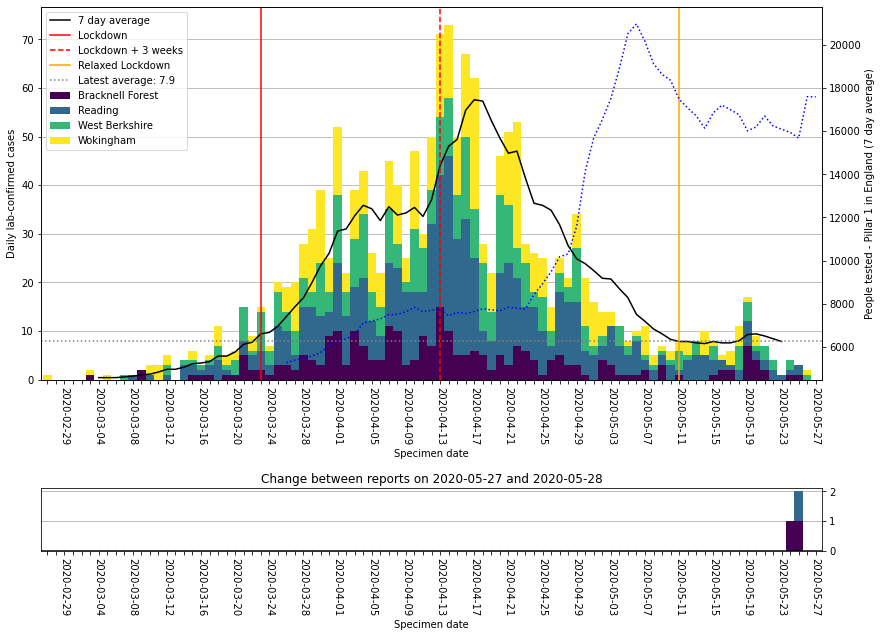

In [10]:
plot(for_date, areas = [wokingham, reading, west_berks, bracknell], uncertain_days=4)

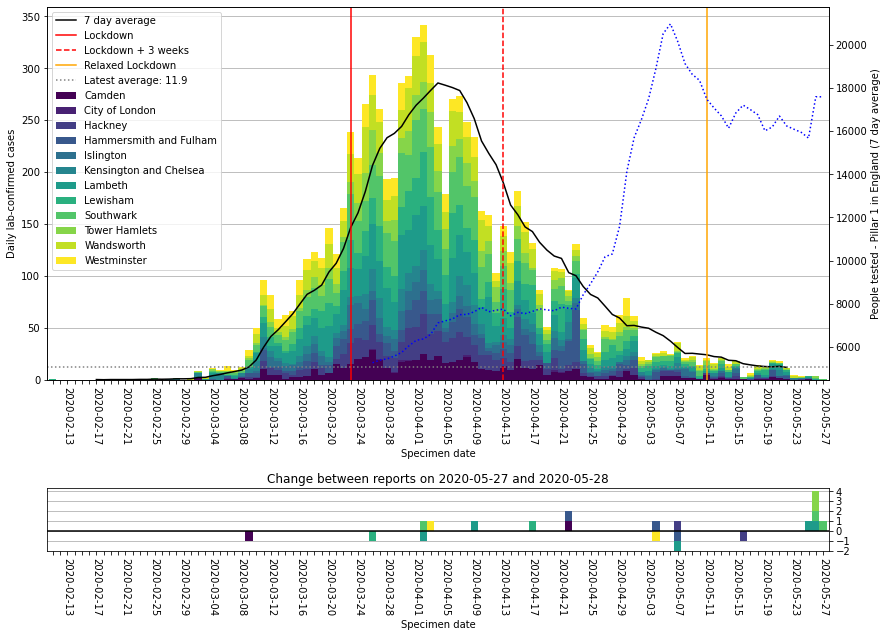

In [11]:
plot(for_date, 
     areas = [southwark, lambeth, wandsworth, hammersmith, kensington, 
              westminster, cambden, islington, hackney, tower_hamlets, lewisham, city_of_london], 
     uncertain_days=5)

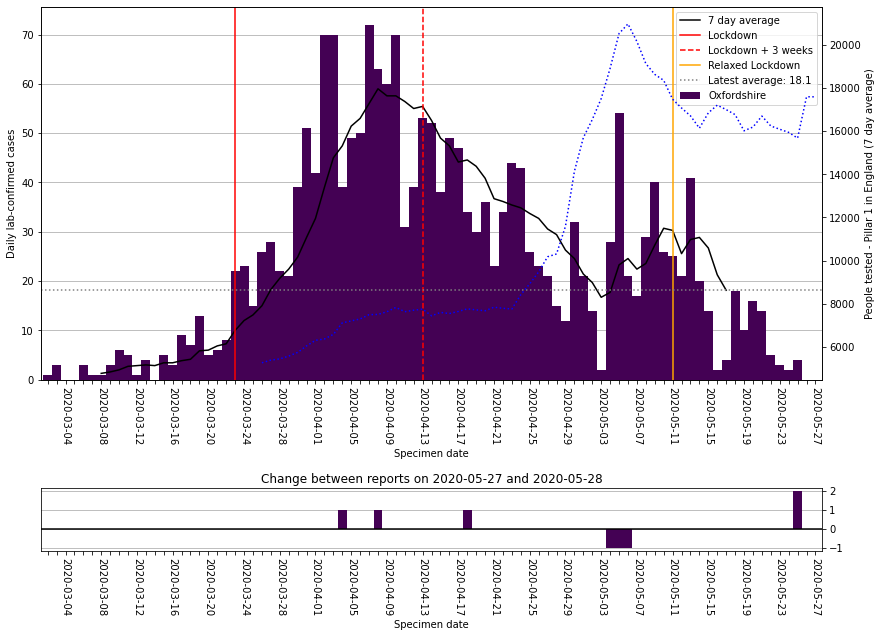

In [12]:
plot(for_date, areas = [oxfordshire], uncertain_days=10, diff_days=1)

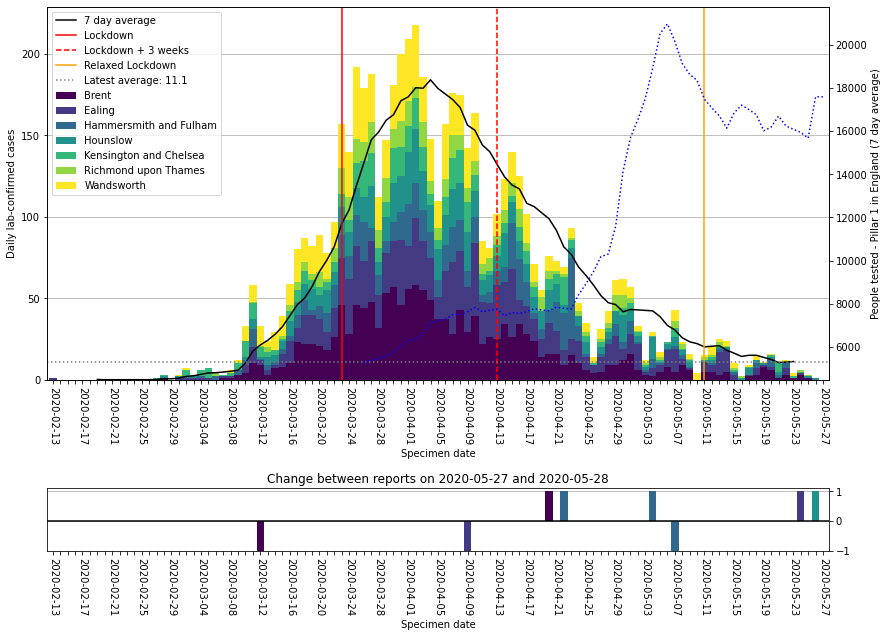

In [13]:
plot(for_date, areas = [hammersmith, kensington, ealing, hounslow, richmond, wandsworth, brent], uncertain_days=4)

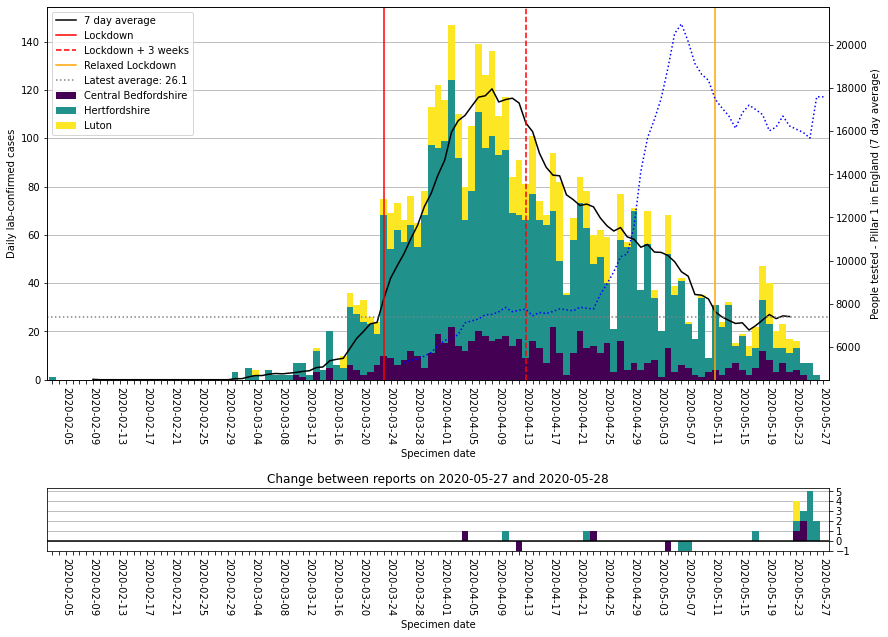

In [14]:
plot(for_date, areas = [hertfordshire, luton, central_bedfordshire], uncertain_days=5)

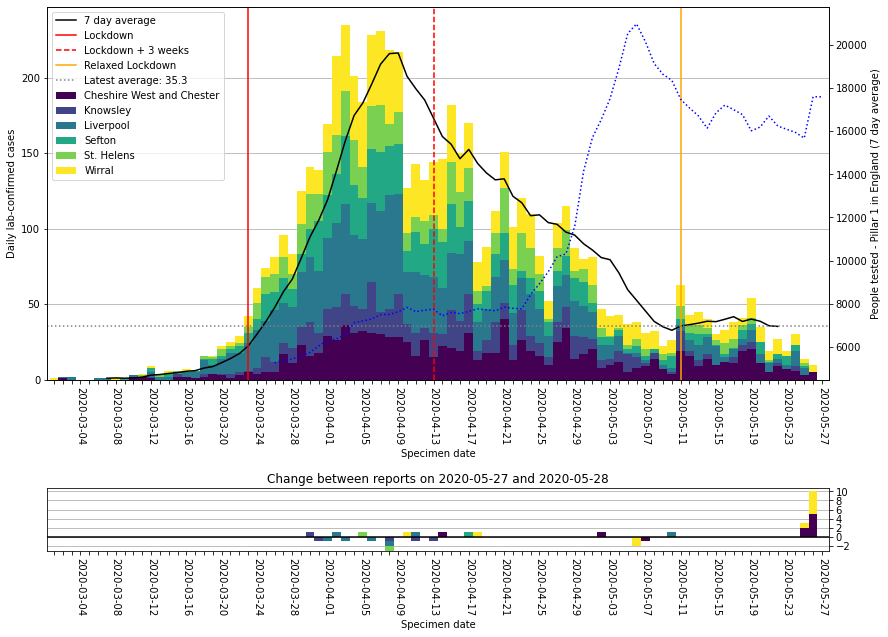

In [15]:
plot(for_date, areas = [wirral, cheshire, liverpool, sefton, knowsley, st_helens], uncertain_days=5)

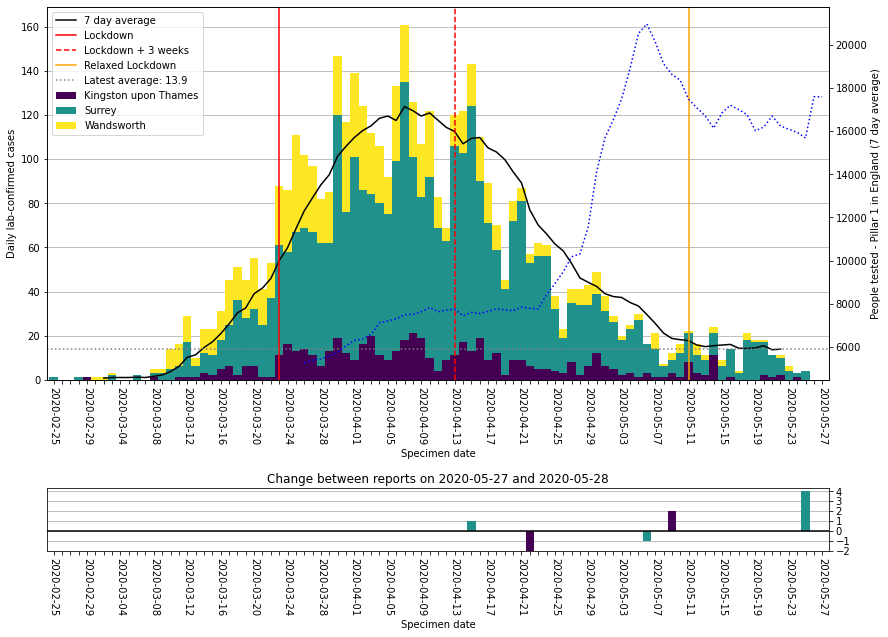

In [16]:
plot(for_date, areas = [kingston, wandsworth, surrey], uncertain_days=5)

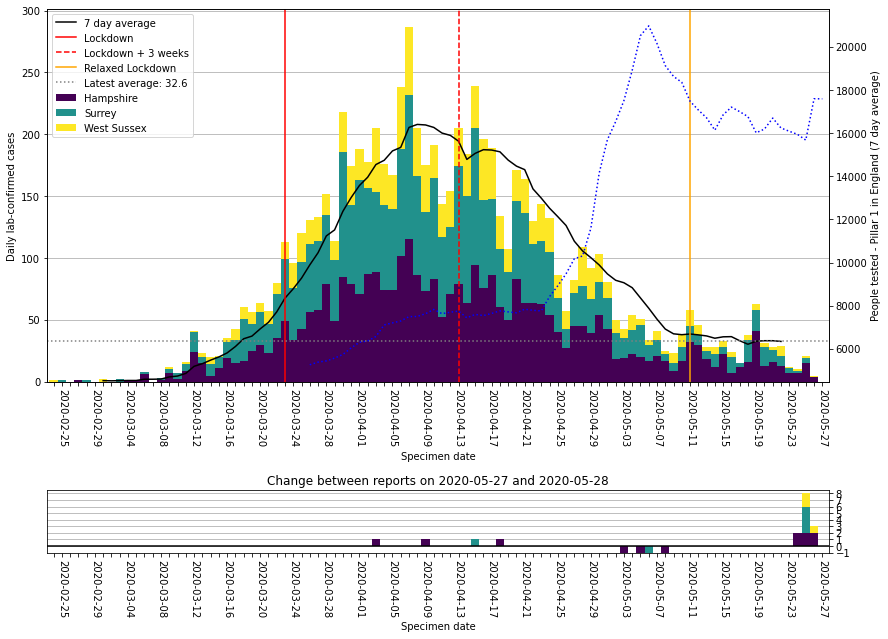

In [17]:
plot(for_date, areas = [surrey, hampshire, west_sussex], uncertain_days=5)